# Using LSTM - Poly

In this notebook, we will train an LSTM layer on the dataset of 5'UTRs with fixed length of 50 nucleotides to predict the distribution of polysome profiles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import sequence

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random

import keras
np.random.seed(1337)

from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Useful Functions

In [30]:
def r2(x,y):
    return 1 - sum((x-y)**2)/sum((x-np.mean(x))**2)

def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


# Data Processing and Analysis

In [2]:
data_path = "Data/GSM3130435_egfp_unmod_1.csv.gz"
df = pd.read_csv(data_path, compression='gzip')
df

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r5,r6,r7,r8,r9,r10,r11,r12,r13,rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,1.365472e-04,1.090036e-04,0.000057,0.000033,0.000015,0.000016,9.415128e-06,0.000009,...,0.033645,0.020343,0.019850,0.017988,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,6.661179e-05,6.952406e-05,0.000065,0.000048,0.000023,0.000020,1.128378e-05,0.000011,...,0.049711,0.028540,0.027431,0.024766,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,8.798774e-05,8.087227e-05,0.000059,0.000035,0.000017,0.000016,8.516738e-06,0.000009,...,0.042436,0.022460,0.025015,0.024275,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,7.773708e-05,7.108933e-05,0.000060,0.000038,0.000025,0.000016,9.738549e-06,0.000009,...,0.041241,0.025793,0.022751,0.022632,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,4.373148e-05,4.452323e-05,0.000050,0.000051,0.000033,0.000026,1.494921e-05,0.000012,...,0.071306,0.040719,0.033335,0.030367,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326028,321695,ACTAACGTGGGGCCTAAACAAGTGCAAACACCCCCACGGACCCCCA...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.796780e-07,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.800000
326029,321690,GAAAGCGGTTGAAACTACTCATACGTACAAGGTAAACATTTAAAAG...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.796780e-07,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.800000
326030,254099,GGCTATGGCCGAAATAAATAAAGCGCGAGCCCGTAGGTACGAGCAA...,1.749259e-07,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
326031,321677,CCGGCCAGTGCGCTGAAATACGTATAAGGTGGGTCGACGTAAAAAA...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.796780e-07,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.800000


In [4]:
test = df[:20000]
train = df[20000:280000]

X_train = one_hot_encode(train, col='utr', seq_len=50)
X_test = one_hot_encode(test, col='utr', seq_len=50)



In [5]:
y_test = np.array([[df["r"+str(i)][j] for i in range(14)] for j in range(20000)])
y_train = df[["r"+str(i) for i in range(14)]][20000:280000]


# Defining and Training the RNN model

In [6]:
batch_size = 100
input_dim = 50
input_dim2 = 4
units = 75
output_size = 13

def train_model(x, y, nodes=40, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()

    #model.add(layers.LSTM(units, input_shape=(input_dim, input_dim2)))
    model.add(keras.layers.RNN(keras.layers.LSTMCell(units), input_shape=(input_dim, input_dim2)))

    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    
    model.add(Dense(y.shape[1]))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    model_name = "model.h5"
    checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only = True, verbose=1)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

    history = model.fit(x, y, validation_data=(X_test,y_test), batch_size=128, epochs=nb_epoch, verbose=1)
    return model, history

In [7]:
model, history = train_model(X_train, y_train, nodes=50, nb_epoch=20)

/Users/ghadinehme/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
2032/2032 [==============================] - 133s 65ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 2/20
2032/2032 [==============================] - 149s 73ms/step - loss: 9.9299e-04 - val_loss: 9.4346e-04
Epoch 3/20
2032/2032 [==============================] - 165s 81ms/step - loss: 8.6248e-04 - val_loss: 5.9757e-04
Epoch 4/20
2032/2032 [==============================] - 162s 80ms/step - loss: 6.7247e-04 - val_loss: 4.9511e-04
Epoch 5/20
2032/2032 [==============================] - 169s 83ms/step - loss: 5.7654e-04 - val_loss: 3.6118e-04
Epoch 6/20
2032/2032 [==============================] - 166s 82ms/step - loss: 5.2092e-04 - val_loss: 3.2266e-04
Epoch 7/20
2032/2032 [==============================] - 165s 81ms/step - loss: 5.0149e-04 - val_loss: 3.1829e-04
Epoch 8/20
2032/2032 [==============================] - 167s 82ms/step - loss: 4.8517e-04 - val_loss: 3.2634e-04
Epoch 9/20
2032/2032 [==============================] - 169s 83ms/step - loss: 4.7605e-04 - val_loss: 2.

In [37]:
model.save('model_rnn_poly_fit.hdf5')

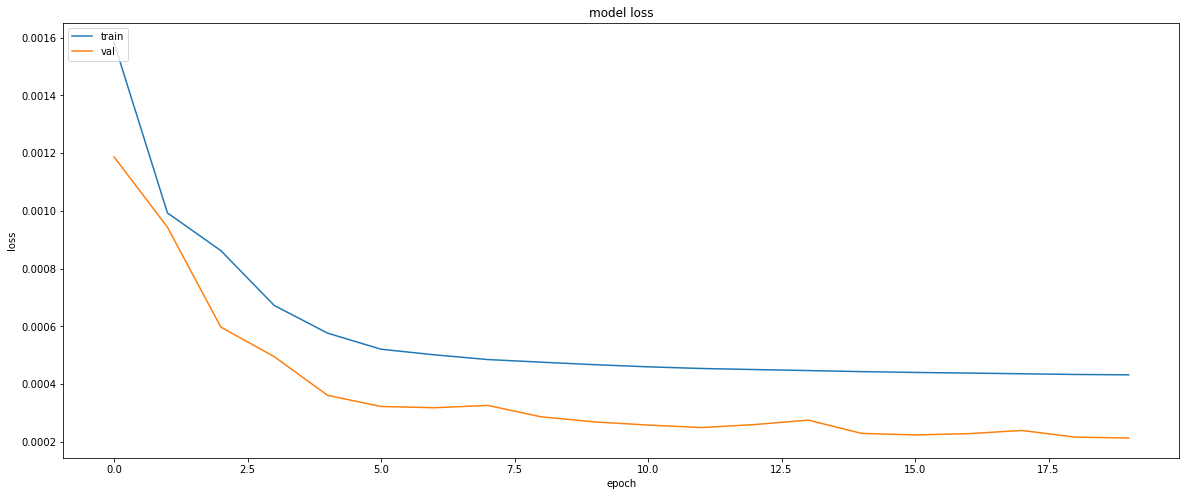

In [13]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Testing the model

In [8]:
predictions = model.predict(X_test).reshape(-1)


625/625 [==============================] - 10s 14ms/step


In [15]:
r = [r2(y_test[:,i], predictions.reshape(20000,14)[:,i]) for i in range(14)]
r

[0.8893393889602496,
 0.9092226508484439,
 0.9281722962913025,
 0.8805045525786845,
 0.7245962258501699,
 0.6880196632342136,
 0.8675396082029215,
 0.9282829133226052,
 0.9253037313851202,
 0.9061296449900502,
 0.8857291429334738,
 0.8857292304675741,
 0.8715955180092003,
 0.7649152912803427]

In [16]:
np.mean(r)

0.8610771327395966

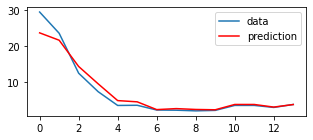

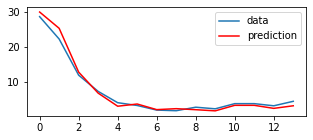

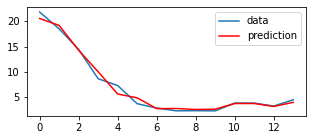

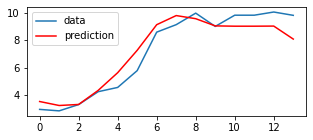

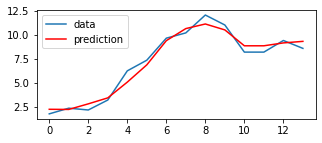

In [17]:
ind = [0,1000,10000,13000,19999]
for i in ind:
    fig = plt.figure(figsize = (5,2))
    plt.plot(y_test[i]*100, label = "data")
    plt.plot(predictions.reshape(20000,14)[i]*100, color = 'r', label = "prediction")
    plt.legend()

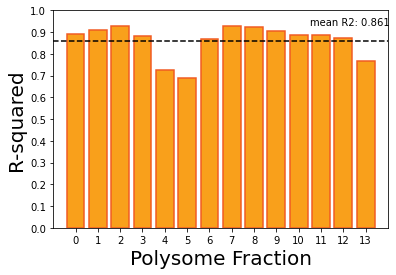

In [18]:
scores = []
for i in range(14):
    pred = predictions.reshape(14,20000)[:,i]
    obs = y_test[i,:]
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    scores.append(round(r_value**2, 3))

scores = r
mean = round(np.array(scores).sum() / len(scores),3)
f, ax = plt.subplots()

ax.bar(x=range(len(scores)),height=scores,align='center',color='#F9A01B',edgecolor='#F15A22', linewidth=1.5)
ax.set_xticks(range(0,14));
ax.set_xlim((-1,14))

ax.set_yticks(np.arange(0,1.01,0.1))
ax.set_yticklabels([round(x,1) for x in np.arange(0,1.01,0.1)])
ax.axhline(mean, linewidth=1.5, ls='dashed', color='k')
ax.text(x=10.5, y=0.93, s='mean R2: ' + str(mean))
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel('Polysome Fraction', size=20)
ax.set_ylabel('R-squared', size=20);